In this notebook, we will run the model and generate the predictions that will be sent to the platform. 

Packages necessary: 

In [13]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet

The function below will be used to get the data saved in the previous step, apply a log transformation (to improve the training process), and split the data into training and testing. We will train and evaluate the model using the data up to `2022-01-01`.

In [14]:
def preprocess_data(filename = './data_3304557.csv'):

    df = pd.read_csv(filename) 

    df.y = np.log(df.y)

    df_train_val = df.loc[df.ds < '2022-01-01']

    return df_train_val, df
    
df_train_val, df = preprocess_data()

The cell below will create the model, split the training data in train and val, and fit the model. The model below uses the last 16 (`n_lags`) observations to predict the following four (`n_forecasts`).

In [15]:
m = NeuralProphet(
    n_lags = 16, 
    ar_layers = [16,16,16,16], 
    quantiles=[0.025, 0.975],
    n_forecasts =  4
)
    
df_train, df_val = m.split_df(df=df_train_val, freq="W", valid_p=0.2)
    
train = m.fit(df=df_train, freq="W",  validation_df = df_val, early_stopping = 50, progress=None)

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (NP.data.processing._handle_missing_data_single_id) - 1 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 1 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.801% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training

Finding best initial lr:   0%|          | 0/219 [00:00<?, ?it/s]

To see the model's output, let's create a function that selects the forecast of the 4 steps ahead and applies an exp transform on the data. In this function, we will transform the data in the format the API accepts for the forecast models. For this class, the prediction element sent to the platform must have at least the following columns: 

* `dates`: with the date of the values forecasted;
* `preds`: with the predictions;
* `lower`: with the lower value of the CI (Nan if the model didn't provide a CI);
* `upper`: with the upper value of the CI (Nan if the model didn't provide a CI);
* `adm_2`: in the Brazil case, the IBGE code (7 - 7-digit) of the city forecasted;
* `adm_1`: in the Brazil case, the UF code (two-letter) of the state forecasted;
* `adm_0`: ISO code of the country forecasted (BR for Brazil);


In the function below, we will keep the column `y` to easiest compare the predictions with what happened, but it will be removed before sending it to the database.

In [42]:
def update_preds(preds, geocode, state, country = 'BR'): 

    
    preds_df = preds.dropna()
    
    preds_df = preds_df[['ds', 'y', 'yhat4', 'yhat4 2.5%', 'yhat4 97.5%']].rename(
                            columns = {'ds':'dates',  'yhat4': 'preds', 'yhat4 2.5%':'lower', 'yhat4 97.5%': 'upper'}
    )

    preds_df[['y','lower', 'preds', 'upper']]  = np.exp(preds_df[['y', 'lower', 'preds', 'upper']])
    
    preds_df['adm_0'] = country
    preds_df['adm_1'] = state
    preds_df['adm_2'] = geocode

    return preds_df 
    
    

Let's see the performance of our model on the train and evaluate dataset. 

In [43]:
preds = m.predict(df_train_val)

preds = update_preds(preds, geocode = 3304557, state = 'RJ')
preds.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.521% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.524% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (NP.data.processing._handle_missing_data_single_id) - 1 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 1 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,dates,y,preds,lower,upper,adm_0,adm_1,adm_2
19,2010-05-16,124.0,53.387798,24.630757,91.659071,BR,RJ,3304557
20,2010-05-23,103.0,54.061824,29.497822,79.110515,BR,RJ,3304557
21,2010-05-30,86.0,109.603664,68.409555,152.254174,BR,RJ,3304557
22,2010-06-06,55.0,84.337601,68.794377,130.403266,BR,RJ,3304557
23,2010-06-13,95.0,56.807755,46.694149,104.332211,BR,RJ,3304557


The function below will be used to plot the predictions: 

In [54]:
def make_plot(ax, preds):
    preds.dates = pd.to_datetime(preds.dates)

    ax.plot(preds.dates, preds.y, label = 'Data', color = 'black')
    
    ax.plot(preds.dates, preds.preds, label = 'Forecast', color = 'tab:orange')

    ax.fill_between(preds.dates, preds.lower, preds.upper, color = 'tab:orange', alpha = 0.3)
    
    ax.legend()
    
    ax.grid()


    ax.set_xlabel('Dates')

    ax.set_ylabel('New cases') 

    for tick in ax.get_xticklabels():
            tick.set_rotation(15)



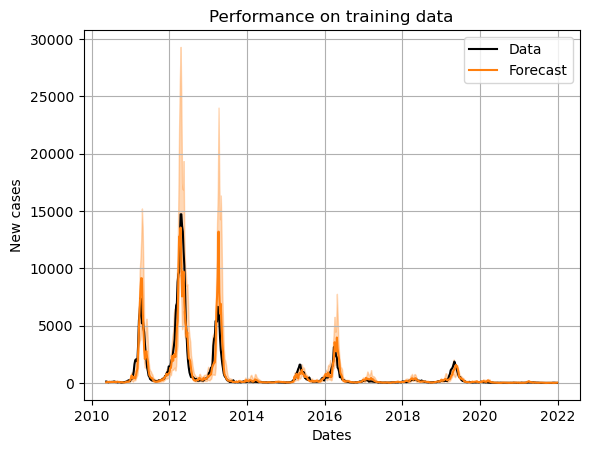

In [49]:
fig, ax = plt.subplots()
make_plot(ax, preds)

ax.set_title('Performance on training data')

plt.show()

In [23]:
preds.tail()

,ds,y,yhat1,yhat2,yhat3,yhat4,yhat1 2.5%,yhat2 2.5%,yhat3 2.5%,yhat4 2.5%,yhat1 97.5%,yhat2 97.5%,yhat3 97.5%,yhat4 97.5%,ar1,ar2,ar3,ar4,trend,season_yearly
621,2021-11-28,3.135494,3.080537,2.619939,2.332464,2.011263,2.784211,2.619939,2.159480,1.723787,3.148105,3.403173,3.385756,2.437499,2.317410,1.856812,1.569337,1.248136,0.909833,-0.146706
622,2021-12-05,2.772589,3.341581,2.867398,1.976736,2.732266,2.902857,2.461749,1.976736,2.525229,3.513513,3.349558,3.611316,3.398861,2.570148,2.095964,1.205302,1.960832,0.905992,-0.134558
623,2021-12-12,1.791759,2.587685,3.171682,3.009925,2.410348,2.097283,2.722049,2.968070,2.410348,2.743028,3.487329,3.771433,3.442595,1.993479,2.577477,2.415720,1.816143,0.902151,-0.307945
624,2021-12-19,1.386294,2.350247,2.967874,3.204345,2.772169,2.070546,2.654985,2.939087,2.673929,2.533540,3.218039,3.784165,3.483623,1.973861,2.591488,2.827959,2.395783,0.898309,-0.521923
625,2021-12-26,1.386294,1.612659,2.723644,3.121704,3.312439,1.199918,2.439525,2.389136,3.085455,2.156546,3.136307,3.320453,3.737713,1.329070,2.440055,2.838115,3.028850,0.894468,-0.610879


Now, let's compute the performance of the model on the training set. Let's get the output of the `preprocess_data` function and plot the predictions after `2022-01-01`:

In [52]:
preds = m.predict(df)

preds = update_preds(preds, geocode = 3304557, state = 'RJ')

preds = preds.loc[preds.dates >= '2022-01-01'] 
preds.head()

INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.574% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
INFO - (NP.df_utils._infer_frequency) - Major frequency W-SUN corresponds to 99.576% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - W
WARNING - (NP.data.processing._handle_missing_data_single_id) - 1 missing values in column y were detected in total. 
INFO - (NP.data.processing._handle_missing_data_single_id) - 1 NaN values in column y were auto-imputed.
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,dates,y,preds,lower,upper,adm_0,adm_1,adm_2
626,2022-01-02,21.0,34.834114,12.885554,46.528976,BR,RJ,3304557
627,2022-01-09,14.0,39.094947,11.391818,45.920316,BR,RJ,3304557
628,2022-01-16,22.0,24.466095,6.515103,29.247823,BR,RJ,3304557
629,2022-01-23,19.0,25.956710,5.757504,30.989697,BR,RJ,3304557
630,2022-01-30,31.0,63.377196,32.071461,83.142347,BR,RJ,3304557


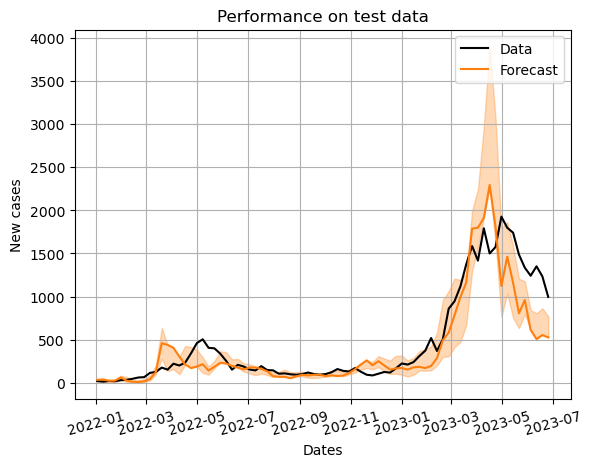

In [55]:
fig, ax = plt.subplots()
make_plot(ax, preds)

ax.set_title('Performance on test data')

plt.show()

Let's save this data on a dataframe that will be used to send the predictions to the mosqlimate platform. 

In [56]:
del preds['y']
preds.to_csv('forecast_3304557.csv', index = False) 